In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pyod.models.alad import ALAD

normal_path = "transients/S01/1/Normal/q_data"
relay_path  = "transients/S01/1/Relay/q_data"

with h5py.File("datasets/transients_cleaned_padded.h5", "r") as f:
    normal_group = f[normal_path]
    relay_group  = f[relay_path]

    n_norm = normal_group["0"].shape[0]
    n_relay = relay_group["0"].shape[0]

    dataset_normal = np.zeros((49666, n_norm))
    dataset_relay  = np.zeros((49666, n_relay))

    for i in range(49666):
        try:
            dataset_normal[i] = normal_group[str(i)][:]
        except KeyError:
            continue

    for i in range(49666):
        try:
            dataset_relay[i] = relay_group[str(i)][:]
        except KeyError:
            continue

scalerMinMax = MinMaxScaler()
scalerStandard = StandardScaler()

X_train               = dataset_normal[:47500]
X_test_normal         = dataset_normal[47500:]
X_test_relay          = dataset_relay[47500:]

scalerMinMax.fit(X_train)
X_train_scaled_minmax       = scalerMinMax.transform(X_train)
X_test_norm_scaled_minmax   = scalerMinMax.transform(X_test_normal)
X_test_relay_scaled_minmax  = scalerMinMax.transform(X_test_relay)

scalerStandard.fit(X_train)
X_train_scaled_standard        = scalerStandard.transform(X_train)
X_test_norm_scaled_standard    = scalerStandard.transform(X_test_normal)
X_test_relay_scaled_standard   = scalerStandard.transform(X_test_relay)

X_test_combined = np.vstack((X_test_normal, X_test_relay))
X_test_combined_scaled_minmax = np.vstack((X_test_norm_scaled_minmax, X_test_relay_scaled_minmax))
X_test_combined_scaled_standard = np.vstack((X_test_norm_scaled_standard, X_test_relay_scaled_standard))

y_true = np.array([0] * len(X_test_normal) + [1] * len(X_test_relay))

latent dim 8
dropout rate 0.05

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.32      0.01      0.01      2166

    accuracy                           0.50      4332
   macro avg       0.41      0.50      0.34      4332
weighted avg       0.41      0.50      0.34      4332



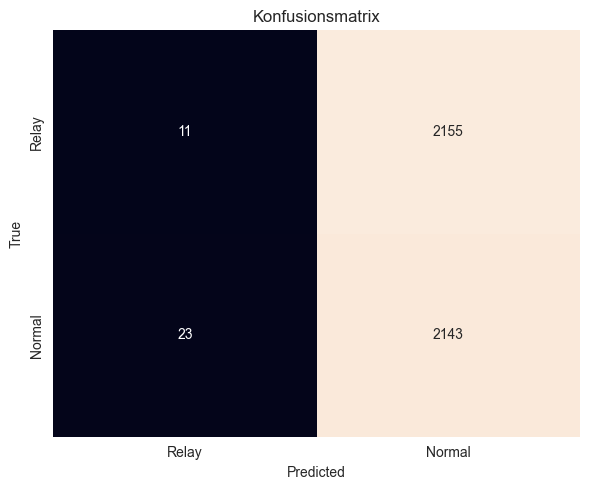

latent dim 8
dropout rate 0.1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.40      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.45      0.50      0.34      4332
weighted avg       0.45      0.50      0.34      4332



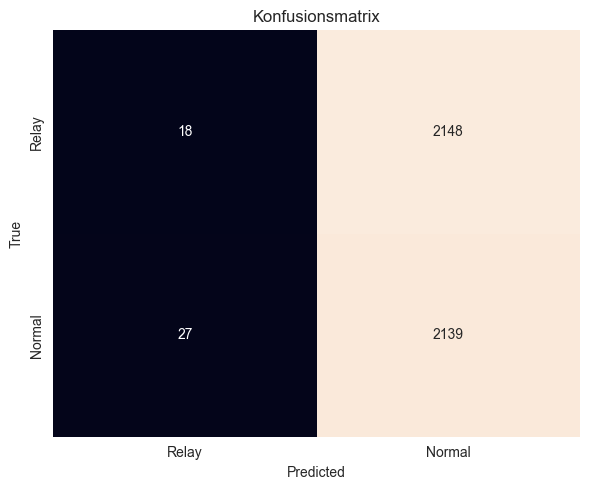

latent dim 8
dropout rate 0.2

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.50      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.50      0.50      0.34      4332
weighted avg       0.50      0.50      0.34      4332



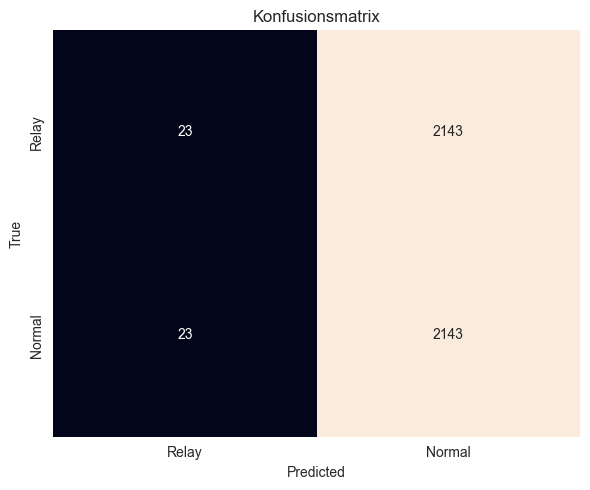

latent dim 2
dropout rate 0.05

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.50      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.50      0.50      0.34      4332
weighted avg       0.50      0.50      0.34      4332



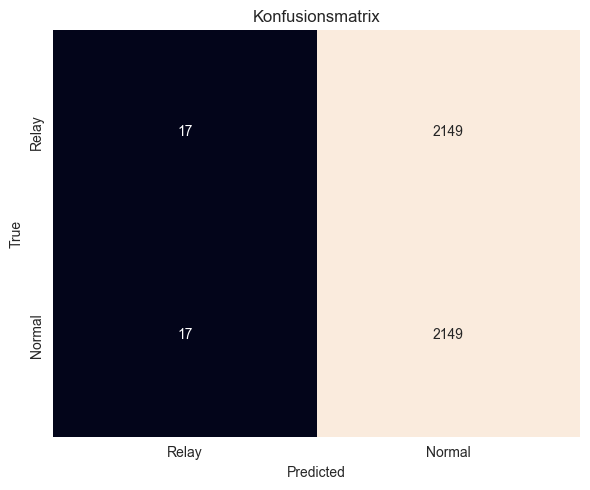

latent dim 2
dropout rate 0.1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.67      2166
       Relay       0.67      0.01      0.03      2166

    accuracy                           0.50      4332
   macro avg       0.59      0.50      0.35      4332
weighted avg       0.59      0.50      0.35      4332



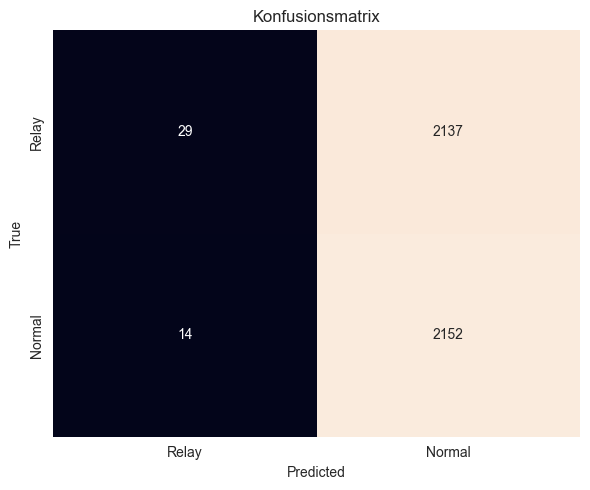

latent dim 2
dropout rate 0.2

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.48      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.49      0.50      0.34      4332
weighted avg       0.49      0.50      0.34      4332



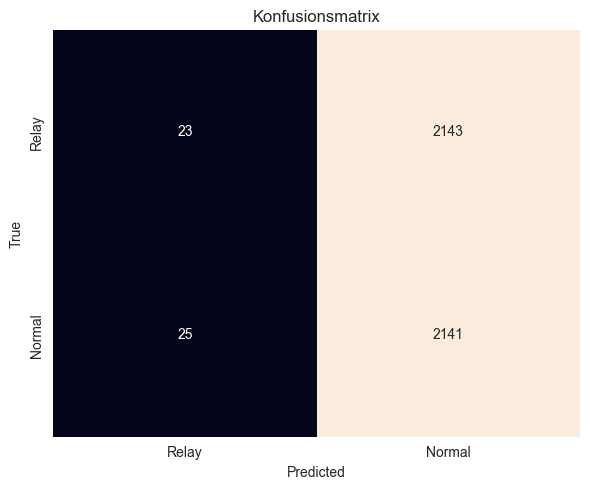

latent dim 32
dropout rate 0.05

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.67      2166
       Relay       0.59      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.54      0.50      0.34      4332
weighted avg       0.54      0.50      0.34      4332



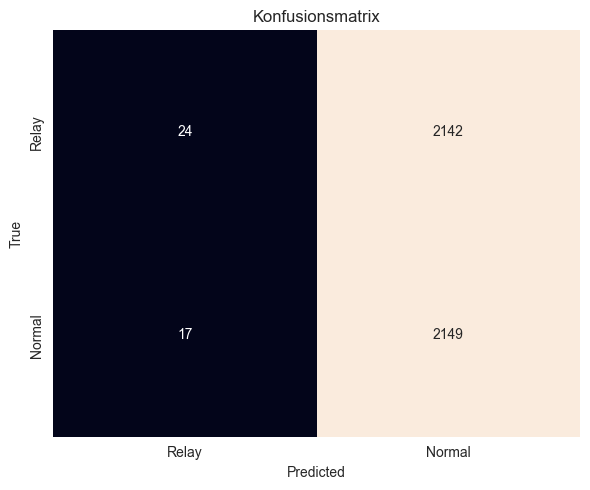

latent dim 32
dropout rate 0.1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.41      0.01      0.01      2166

    accuracy                           0.50      4332
   macro avg       0.45      0.50      0.34      4332
weighted avg       0.45      0.50      0.34      4332



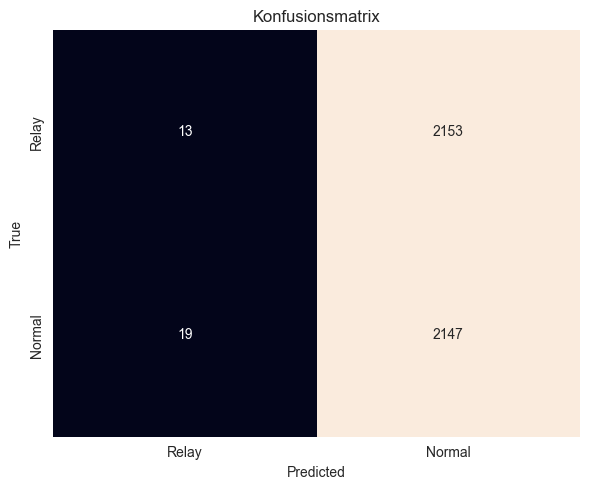

latent dim 32
dropout rate 0.2

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.39      0.01      0.01      2166

    accuracy                           0.50      4332
   macro avg       0.44      0.50      0.34      4332
weighted avg       0.44      0.50      0.34      4332



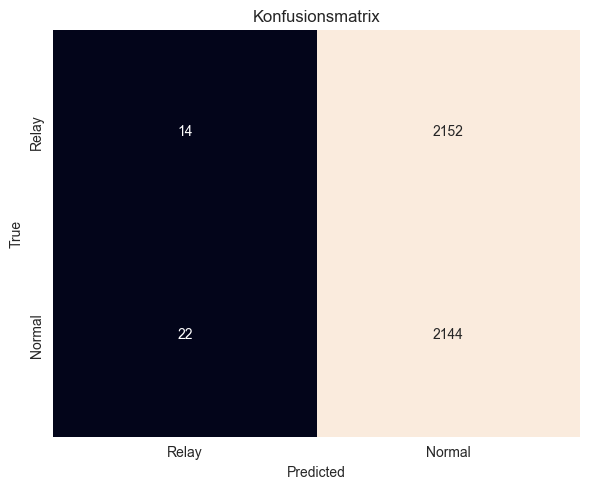

In [2]:
for l in {2,8,32}:
    for d in {0.05,0.1,0.2}:
        clf = ALAD(contamination=0.01, latent_dim=l, dropout_rate=d, enc_layers=[100,50,25], dec_layers=[25, 50, 100])
        clf.fit(X_train)

        # pyod.predict: 0 = inlier, 1 = outlier
        y_pred = clf.predict(X_test_combined)

        # cm und report
        cm = confusion_matrix(y_true, y_pred, labels=[1,0])
        print(f"latent dim {l}")
        print(f"dropout rate {d}")
        print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

        # plot
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d",
                    xticklabels=["Relay","Normal"],
                    yticklabels=["Relay","Normal"],
                    cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Konfusionsmatrix")
        plt.tight_layout()
        plt.show()

latent dim 8
dropout rate 0.05

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.98      0.66      2166
       Relay       0.38      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.44      0.50      0.34      4332
weighted avg       0.44      0.50      0.34      4332



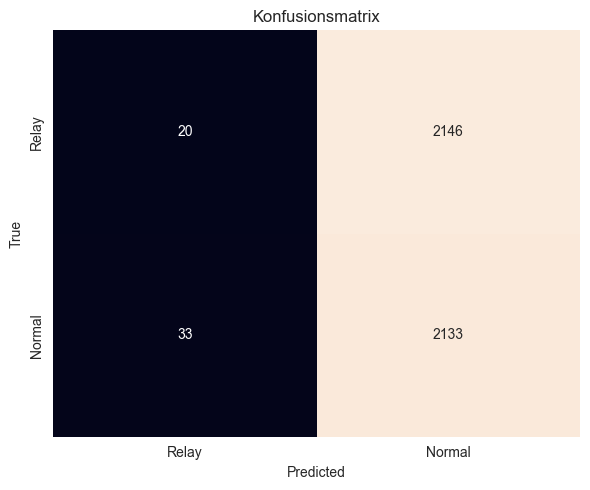

latent dim 8
dropout rate 0.1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.21      0.00      0.01      2166

    accuracy                           0.50      4332
   macro avg       0.35      0.50      0.33      4332
weighted avg       0.35      0.50      0.33      4332



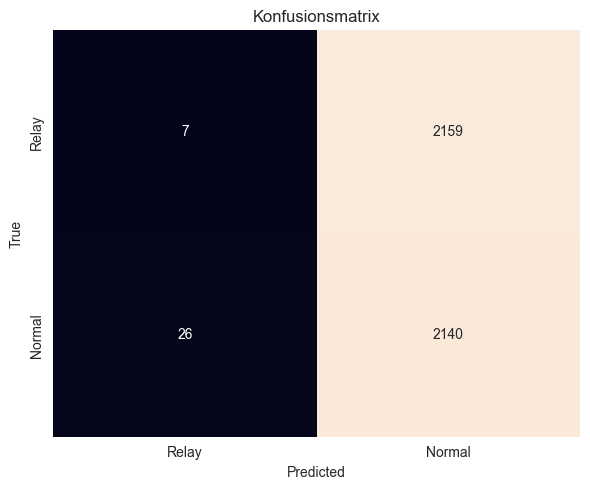

latent dim 8
dropout rate 0.2

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.49      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.49      0.50      0.34      4332
weighted avg       0.49      0.50      0.34      4332



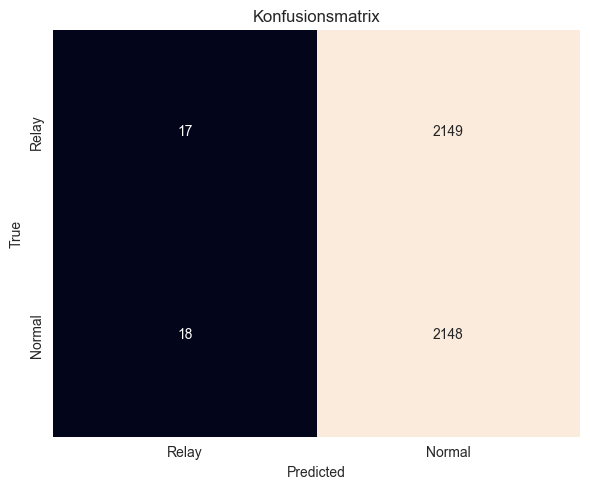

latent dim 2
dropout rate 0.05

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.39      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.45      0.50      0.34      4332
weighted avg       0.45      0.50      0.34      4332



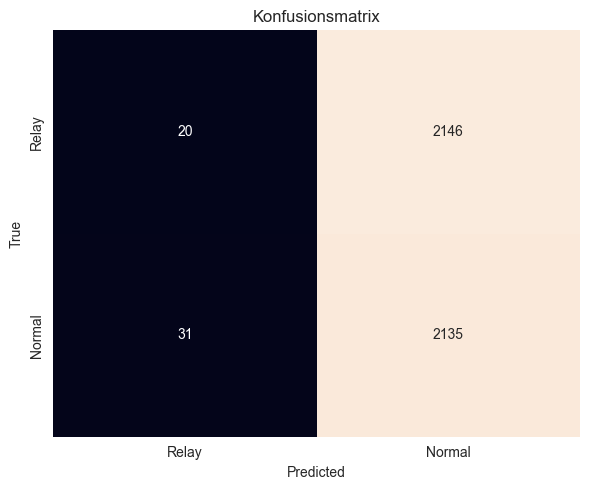

latent dim 2
dropout rate 0.1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.49      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.49      0.50      0.34      4332
weighted avg       0.49      0.50      0.34      4332



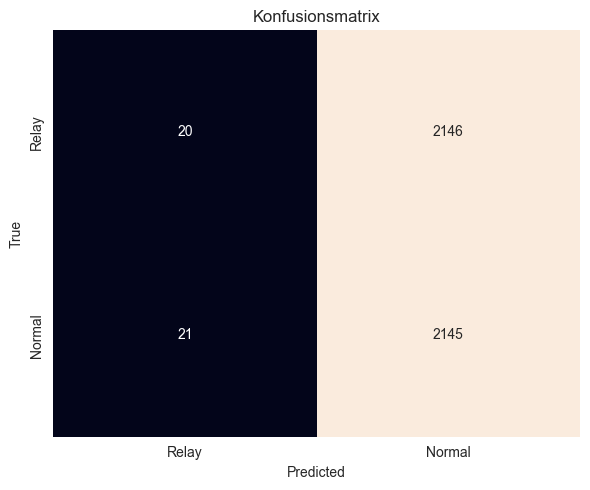

latent dim 2
dropout rate 0.2

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.67      2166
       Relay       0.51      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.51      0.50      0.34      4332
weighted avg       0.51      0.50      0.34      4332



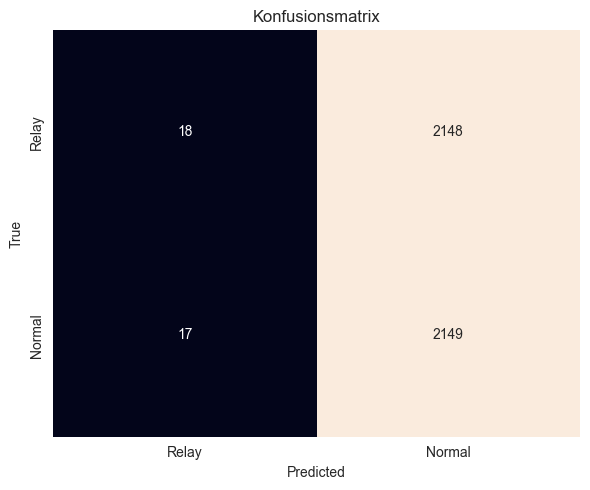

latent dim 32
dropout rate 0.05

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.38      0.01      0.01      2166

    accuracy                           0.50      4332
   macro avg       0.44      0.50      0.34      4332
weighted avg       0.44      0.50      0.34      4332



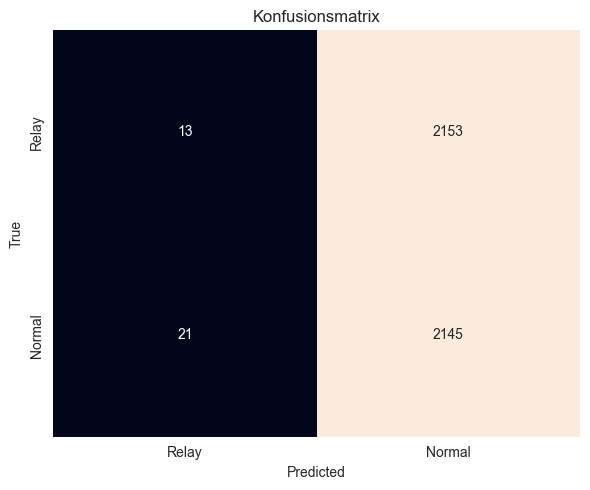

latent dim 32
dropout rate 0.1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.34      0.01      0.01      2166

    accuracy                           0.50      4332
   macro avg       0.42      0.50      0.34      4332
weighted avg       0.42      0.50      0.34      4332



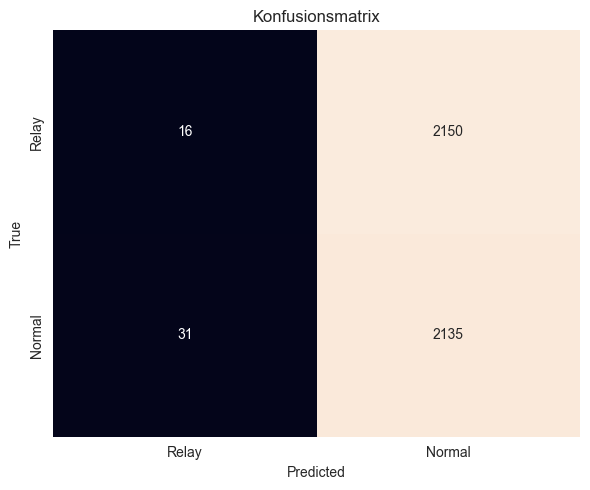

latent dim 32
dropout rate 0.2

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.52      0.01      0.03      2166

    accuracy                           0.50      4332
   macro avg       0.51      0.50      0.35      4332
weighted avg       0.51      0.50      0.35      4332



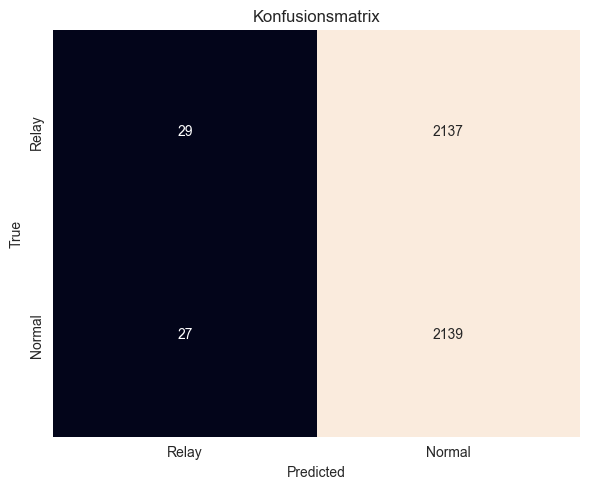

In [3]:
for l in {2,8,32}:
    for d in {0.05,0.1,0.2}:
        clf = ALAD(contamination=0.01, latent_dim=l, dropout_rate=d, enc_layers=[100,50,25], dec_layers=[25, 50, 100])
        clf.fit(X_train_scaled_standard)

        # pyod.predict: 0 = inlier, 1 = outlier
        y_pred = clf.predict(X_test_combined_scaled_standard)

        # cm und report
        cm = confusion_matrix(y_true, y_pred, labels=[1,0])
        print(f"latent dim {l}")
        print(f"dropout rate {d}")
        print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

        # plot
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d",
                    xticklabels=["Relay","Normal"],
                    yticklabels=["Relay","Normal"],
                    cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Konfusionsmatrix")
        plt.tight_layout()
        plt.show()

latent dim 8
dropout rate 0.05

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.45      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.48      0.50      0.34      4332
weighted avg       0.48      0.50      0.34      4332



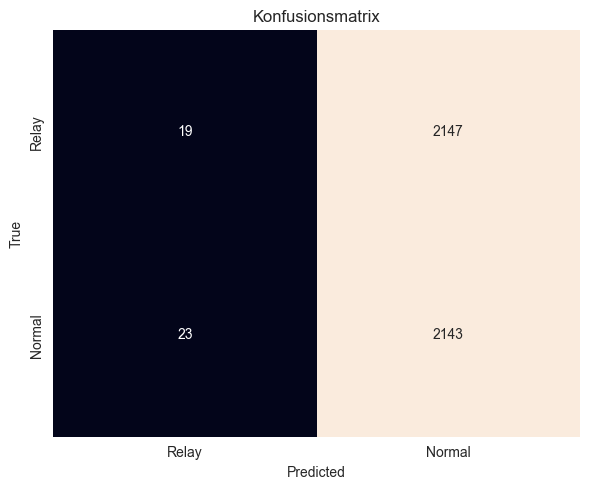

latent dim 8
dropout rate 0.1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.44      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.47      0.50      0.34      4332
weighted avg       0.47      0.50      0.34      4332



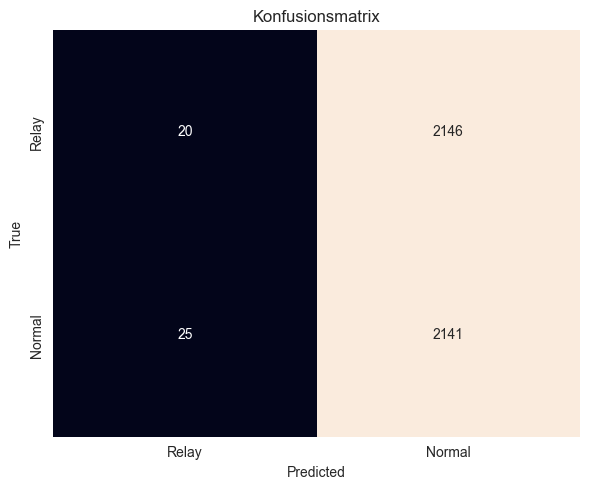

latent dim 8
dropout rate 0.2

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.46      0.01      0.01      2166

    accuracy                           0.50      4332
   macro avg       0.48      0.50      0.34      4332
weighted avg       0.48      0.50      0.34      4332



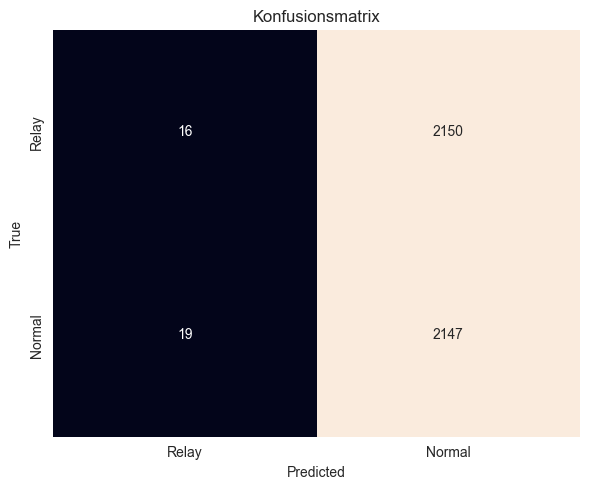

latent dim 2
dropout rate 0.05

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.49      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.49      0.50      0.34      4332
weighted avg       0.49      0.50      0.34      4332



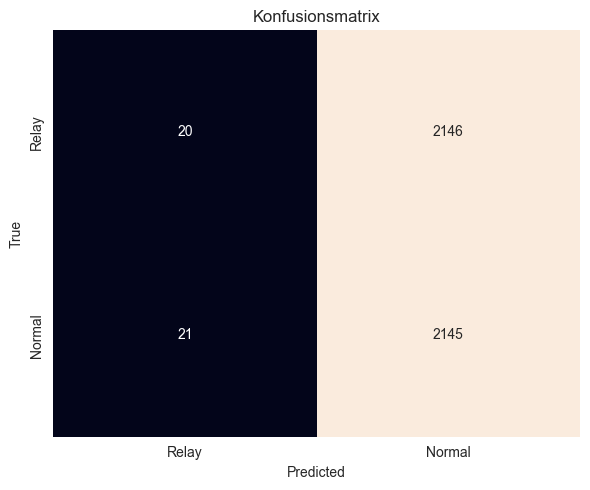

latent dim 2
dropout rate 0.1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.47      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.49      0.50      0.34      4332
weighted avg       0.49      0.50      0.34      4332



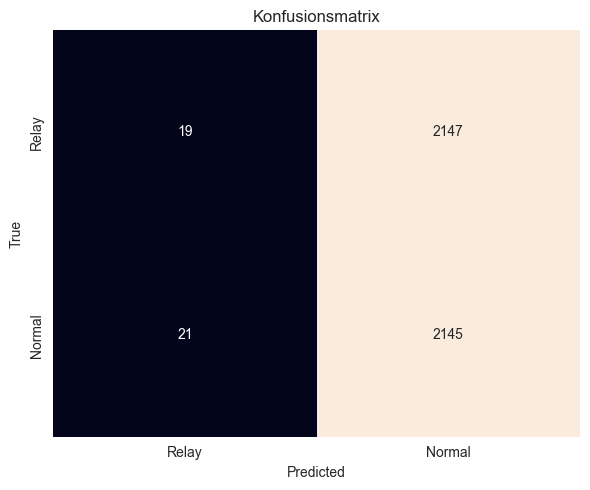

latent dim 2
dropout rate 0.2

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.44      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.47      0.50      0.34      4332
weighted avg       0.47      0.50      0.34      4332



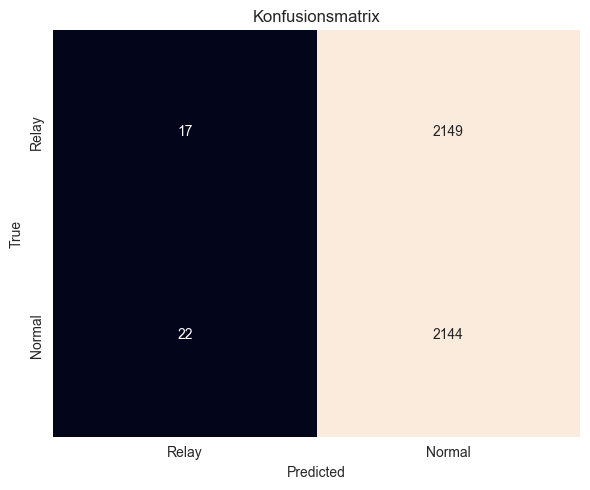

latent dim 32
dropout rate 0.05

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.52      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.51      0.50      0.34      4332
weighted avg       0.51      0.50      0.34      4332



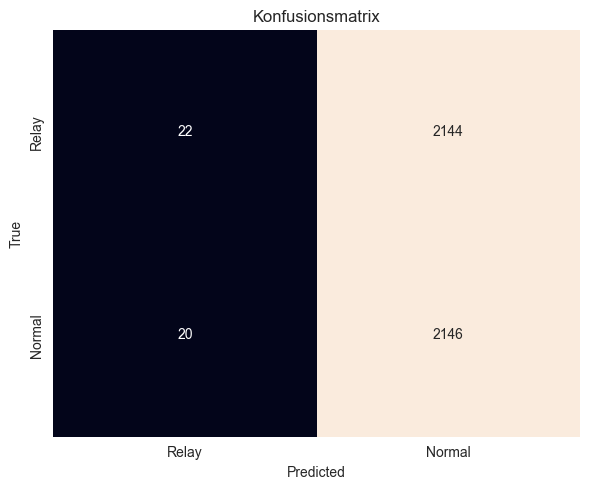

latent dim 32
dropout rate 0.1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.66      2166
       Relay       0.52      0.01      0.02      2166

    accuracy                           0.50      4332
   macro avg       0.51      0.50      0.34      4332
weighted avg       0.51      0.50      0.34      4332



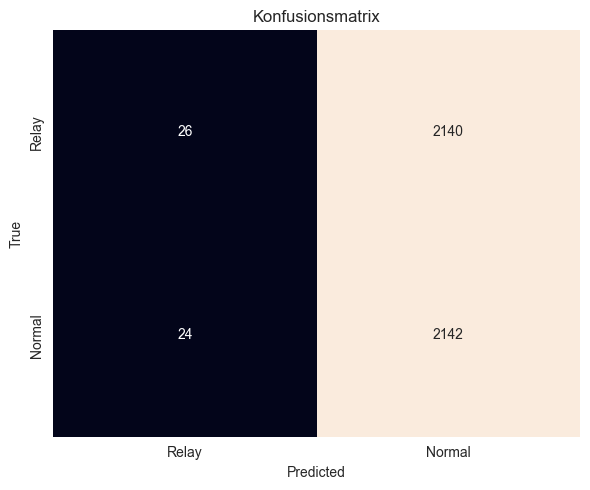

latent dim 32
dropout rate 0.2

Classification Report:
               precision    recall  f1-score   support

      Normal       0.50      0.99      0.67      2166
       Relay       0.63      0.01      0.03      2166

    accuracy                           0.50      4332
   macro avg       0.57      0.50      0.35      4332
weighted avg       0.57      0.50      0.35      4332



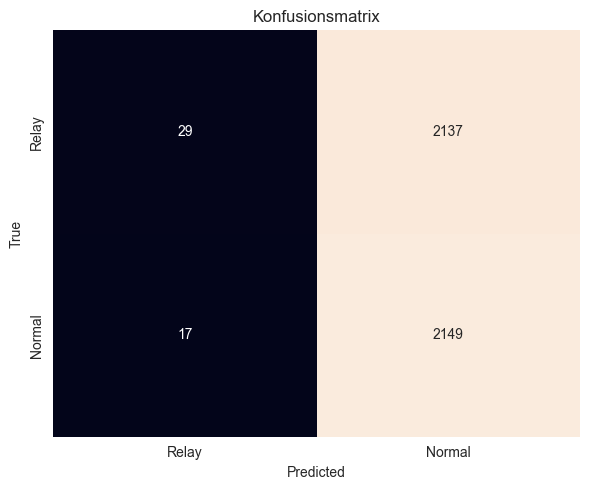

In [4]:
for l in {2,8,32}:
    for d in {0.05,0.1,0.2}:
        clf = ALAD(contamination=0.01, latent_dim=l, dropout_rate=d, enc_layers=[100,50,25], dec_layers=[25, 50, 100])
        clf.fit(X_train_scaled_minmax)

        # pyod.predict: 0 = inlier, 1 = outlier
        y_pred = clf.predict(X_test_combined_scaled_minmax)

        # cm und report
        cm = confusion_matrix(y_true, y_pred, labels=[1,0])
        print(f"latent dim {l}")
        print(f"dropout rate {d}")
        print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

        # plot
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d",
                    xticklabels=["Relay","Normal"],
                    yticklabels=["Relay","Normal"],
                    cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Konfusionsmatrix")
        plt.tight_layout()
        plt.show()